# Lightning affect on tropospheric NO2


This notebook analyzes time series of tropospheric nitrogen dioxide from TEMPO L2 product at locations of the most powerful lightnings selected from GLM L3 product.
The key steps of the algorithm are:
1) take user input on the date of interest;
2) search for and download GLM GOES-16 granules timed between 1500 UTC and 1700 UTC on the user selcted date, this shoud yield 60 granules of GLM product;
3) select the most powerful lightning from every GLM granule falling into TEMPO domain;
4) search for and download all TEMPO NO2 L2 granules in the timespan 3 hours before to 3 hours after the lightning event covering the lighning location;
5) average all NO2 tropospheric column retrievals withing 10 km of the lightning location;
6) analyse increase of NO2 after the strike as a function of the lightning power, plot a graph.


# Installing necessary libraries

In [1]:
# Install external dependencies
#!pip install -qq harmony-py python-cmr 
!pip install -qq gnss_lib_py # this is needed to work with GPS time
! pip3 install geopy # this is needed to compute distance between geolocations given by (latitude, longitude) pairs

# Importing necessary librairies

In [9]:
import earthaccess # needed to discover and download TEMPO data
import netCDF4 as nc # needed to read TEMPO data

import os
import sys

import platform
from subprocess import Popen
import shutil

from shapely.geometry import Point, Polygon # needed to search a point within a polygon
from scipy.interpolate import griddata # needed to interpolate TEMPO data to the point of interest
from scipy.signal import find_peaks
from scipy import stats # needed for linear regression analysis

import requests # needed to search for and download Pandora data
import codecs # needed to read Pandora data
import numpy as np

import matplotlib.pyplot as plt # needed to plot the resulting time series
from matplotlib.pyplot import cm
from matplotlib import ticker
from pathlib import Path # needed to check whether a needed data file is already downloaded
from datetime import datetime, timedelta, timezone # needed to work with time in plotting time series

import getpass
import traceback
from typing import Dict

import cmr
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

import gnss_lib_py as glp

import geopy.distance as geodist

# defining functions

## function to read GLM product

In [3]:
def read_GLM_L3(fn):
  var_name = 'Total_Optical_energy'

  try:
    ds = nc.Dataset(fn)

    var = ds.variables[var_name] # this reads variable column_amount_o3 from prod (group product, /product)
    tot_opt_energy = np.ma.getdata(var[:])
    fv = var.getncattr('_FillValue')

    ds.close()

  except:
    print('variable '+var_name+' cannot be read in file '+fn)
    tot_opt_energy = 0
    fv = 0

  return tot_opt_energy, fv

## function to read GLM geolocation
this is standalone file with fixed positions, it nedds to be read only one time

In [4]:
def read_GLM_geolocation(fn):
  lat_name = 'latitude'
  lon_name = 'longitude'

  try:
    ds = nc.Dataset(fn)

    var = ds.variables[lat_name] # this reads variable column_amount_o3 from prod (group product, /product)
    lat = np.ma.getdata(var[:])
    fv_lat = var.getncattr('_FillValue')

    var = ds.variables[lon_name] # this reads variable column_amount_o3 from prod (group product, /product)
    lon = np.ma.getdata(var[:])
    fv_lon = var.getncattr('_FillValue')

    ds.close()

  except:
    print('geolocations cannot be read in file '+fn)
    lat = 0.
    fv_lat = 0.
    lon = 0.
    fv_lon = 0.

  return lat, fv_lat, lon, fv_lon

## function to read subsets of TEMPO_NO2_l2_V03
it also reads full (not subsetted) files

In [5]:
def read_TEMPO_NO2_subset(fname):

    try:
        ds = nc.Dataset(fn)

        geo = ds.groups['geolocation']
        var = geo.variables['time'] # this reads variable column_amount_o3 from prod (group product, /product)
        time = np.ma.getdata(var[:])

        var = geo.variables['latitude'] # this reads variable column_amount_o3 from prod (group product, /product)
        lat = np.ma.getdata(var[:])
        fv_lat = var.getncattr('_FillValue')

        var = geo.variables['longitude'] # this reads variable column_amount_o3 from prod (group product, /product)
        lon = np.ma.getdata(var[:])
        fv_lon = var.getncattr('_FillValue')

        prod = ds.groups['product'] # this opens group product, /product, as prod
        var = prod.variables['vertical_column_troposphere'] # this reads variable vertical_column from prod (group product, /product)
        NO2_trop_col = np.ma.getdata(var[:])
        fv_NO2_trop_col = var.getncattr('_FillValue')

        var = prod.variables['vertical_column_troposphere_uncertainty'] # this reads variable vertical_column_uncertainty from prod (group product, /product)
        NO2_trop_col_unc = np.ma.getdata(var[:])
        fv_NO2_trop_col_unc = var.getncattr('_FillValue')

        var = prod.variables['main_data_quality_flag'] # this reads variable main_data_quality_flag from prod (group product, /product)
        NO2_trop_col_QF = np.ma.getdata(var[:])
        fv_QF = var.getncattr('_FillValue')

        ds.close()

    except:
        time = 0.
        lat = 0.
        fv_lat = 0.
        lon = 0.
        fv_lon = 0.
        NO2_trop_col = 0.
        fv_NO2_trop_col = 0.
        NO2_trop_col_unc = 0.
        fv_NO2_trop_col_unc = 0.
        NO2_trop_col_QF = 0.
        fv_QF = 0.

    return time, lat, fv_lat, lon, fv_lon\
, NO2_trop_col, fv_NO2_trop_col\
, NO2_trop_col_unc, fv_NO2_trop_col_unc\
, NO2_trop_col_QF, fv_QF

## define TEMPO polygon
to be used to determine whether a lightning strike is withing the TEMPO FOR

In [6]:
TEMPO_polygon_vertices = np.array([\
[-164.05212113312515, 57.580692744343764],\
[-159.62557694367206, 64.00214812764455],\
[-159.5105020213036, 64.03988071151218],\
[-125.74252334603875, 59.84139396445069],\
[-96.05408143979784, 57.88132621249599],\
[-64.56768816548264, 58.97778982560536],\
[-22.46881851738449, 64.04465321370128],\
[-22.387959464221932, 64.01783666879393],\
[-19.91901109996412, 61.67008505136229],\
[-20.02912784792555, 61.013076433111166],\
[-38.475213364618575, 55.75035627543793],\
[-50.928764927622005, 47.561189914648295],\
[-60.04304645882562, 34.96704838894501],\
[-65.43091260059765, 17.80494156985626],\
[-65.52650442132435, 17.734894347761642],\
[-92.90089768139569, 17.472210121580602],\
[-120.00997152337513, 17.83460481223918],\
[-120.10406036956257, 17.90124573150081],\
[-125.594442750272, 33.416995150542284],\
[-134.56658868971982, 44.985729486987566],\
[-147.2781990151187, 52.91909149516611],\
[-163.9958247687396, 57.427386380073756],\
[-164.05212113312515, 57.580692744343764]])

TEMPO_polygon = Polygon(TEMPO_polygon_vertices)

# Main code begins here

# Establishing access to EarthData

## with harmony-py library

In [7]:
print('Please provide your Earthdata Login credentials to allow data access')
print('Your credentials will only be passed to Earthdata and will not be exposed in the notebook')
username = input('Username:')

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to Earthdata and will not be exposed in the notebook


Username: alexrad71
 ········


## with earthaccess library

In [8]:
#User needs to create an account at https://www.earthdata.nasa.gov/
#Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

# Working with GLM data

## Selecting date of interest for GLM

In [9]:
print('enter period of interest, start and end dates, in the form YYYYMMDD')
datestamp = input('enter date of interest ')

DOI = int(datestamp) # date of interest

yyyy = DOI//10000
mm = (DOI//100 - yyyy*100)
dd = (DOI - yyyy*10000 - mm*100)

print(yyyy, mm, dd)

date_start = str('%4.4i-%2.2i-%2.2i 15:00:00' %(yyyy, mm, dd))
date_end = str('%4.4i-%2.2i-%2.2i 16:59:59' %(yyyy, mm, dd))

enter period of interest, start and end dates, in the form YYYYMMDD


enter date of interest  20240701


2024 7 1


## Searching GLM data files

In [10]:
short_name = 'glmgoesL3'
version = '1'
POI_results = earthaccess.search_data(short_name = short_name\
                                      , version = version\
                                      , temporal = (date_start, date_end))

n_gr = len(POI_results)
if n_gr == 0:
  print('program terminated')
  sys.exit()

## 5.2 Printing explicit links to the granules and downloading the files
granule_links = []
for result in POI_results:
    link = result.data_links()[0]
    if "G16" in link: granule_links.append(link)

print(len(granule_links), 'granules were found between', date_start, 'and', date_end)
#for link in granule_links: print(link)

121 granules were found between 2024-07-01 15:00:00 and 2024-07-01 16:59:59


# Read GLM granules* and select a few most powerful strikes** in each granule falling into TEMPO FOR
since most powerful strikes are selected by optical energy, peaks can be very close to each other,
i.e., they belong to the same lightning event. To avoid duplications, the lightning events are separated by distance, see distance_cutoff, so that if the next energy peak is closer to the previous one than that distance, it is ignored.

*) in the example below only first 4 granules are processed, see n_granules. If all granules need to be processed, remove that parameter

**) see n_most_powerful - the number of most powerful strikes in each GLM granule.

In [11]:
n_granules = 4
n_most_powerful = 10 # number of most powerfull strikes to retain for further analysis

distance_cutoff = 20. # distance cutoff, km; if next strike is less than this cutoff from all previous ones, it is discarded

flash_all = np.empty([0, n_most_powerful, 3])
times = np.empty([0])

geo_name = "goes16_abi_full_disk_interpolated_lat_lon.nc"
lat, fv_lat, lon, fv_lon = read_GLM_geolocation(geo_name)
lat_flat = lat.flatten()
lon_flat = lon.flatten()

i = -1
for link in granule_links[:n_granules]:
    i += 1
# determine GLM granule name and time
    GLM_name = link.split('/')[-1]
    print(GLM_name)
    time_pos = GLM_name.index('_e') + 2
    time_string = GLM_name[time_pos : time_pos + 15]
    granule_time = datetime.strptime(time_string[0:13], "%Y%j%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

# download GLM granule and read lightning total energy and positions
    results = earthaccess.download(link, local_path='.')
    tot_opt_energy, fv = read_GLM_L3(GLM_name)
    tot_opt_energy_flat = tot_opt_energy.flatten()

# find peak lightning total energies and sort them
    peak_indices, _ = find_peaks(tot_opt_energy_flat)
    tot_opt_energy_geo = np.stack((lat_flat[peak_indices], lon_flat[peak_indices], tot_opt_energy_flat[peak_indices]), axis = 1)
    tot_opt_energy_geo_sorted = tot_opt_energy_geo[tot_opt_energy_geo[:, 2].argsort()[::-1]]

# select n_most_powerful strikes from the GLM granule falling into TEMPO FOR
    i_most_powerful = 0
    flash_granule = np.empty([0, 3])
    for flash in tot_opt_energy_geo_sorted:
        pp = np.array([flash[1], flash[0]]) # flash[0] - latitude, flash[1] - longitude
        p = Point(pp)
        if not p.within(TEMPO_polygon): continue

        far_enough = True
        for previous_flash in flash_granule:
            distance = geodist.geodesic(previous_flash[0:2], flash[0:2]).km
            if distance < distance_cutoff:
                far_enough = False
                break

        if not far_enough: continue

        print(granule_time+"  %9.6f %10.6f %11.4e" %(flash[0], flash[1], flash[2]))
        flash_granule = np.append(flash_granule, [flash], axis = 0)
        i_most_powerful += 1
        if i_most_powerful >= n_most_powerful: break


    times = np.append(times, granule_time)
    flash_all = np.append(flash_all, [flash_granule], axis = 0)

print(times.shape)
print(flash_all.shape)

OR_GLM-L3-GLMF-M6_G16_s202418314590000_e202418315000000_c20241831500530.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

2024-07-01 15:00:00  49.427891 -97.125038  2.2432e-04
2024-07-01 15:00:00  33.363506 -78.353119  5.1883e-05
2024-07-01 15:00:00  33.838406 -77.028145  4.8831e-05
2024-07-01 15:00:00  36.006439 -73.278831  3.9675e-05
2024-07-01 15:00:00  48.964268 -96.880623  3.8149e-05
2024-07-01 15:00:00  38.142849 -69.296265  3.6623e-05
2024-07-01 15:00:00  49.513691 -96.125099  3.3571e-05
2024-07-01 15:00:00  49.180721 -97.679680  3.3571e-05
2024-07-01 15:00:00  24.943949 -66.097160  3.3571e-05
2024-07-01 15:00:00  28.482164 -84.708115  3.3571e-05
OR_GLM-L3-GLMF-M6_G16_s202418315000000_e202418315010000_c20241831501580.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

2024-07-01 15:01:00  43.894638 -108.298058  1.2513e-04
2024-07-01 15:01:00  39.752754 -66.942810  1.1140e-04
2024-07-01 15:01:00  49.564499 -97.066879  1.0224e-04
2024-07-01 15:01:00  49.356102 -97.086754  8.3928e-05
2024-07-01 15:01:00  28.277439 -87.095146  6.2565e-05
2024-07-01 15:01:00  39.667763 -67.152565  6.2565e-05
2024-07-01 15:01:00  48.689468 -96.867477  5.9513e-05
2024-07-01 15:01:00  48.965431 -98.742561  5.4935e-05
2024-07-01 15:01:00  33.316673 -78.529480  5.0357e-05
2024-07-01 15:01:00  49.262997 -98.515854  4.5779e-05
OR_GLM-L3-GLMF-M6_G16_s202418315010000_e202418315020000_c20241831502570.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

2024-07-01 15:02:00  44.771778 -108.303505  2.6399e-04
2024-07-01 15:02:00  47.532993 -97.200775  8.2402e-05
2024-07-01 15:02:00  33.387478 -78.354195  6.5617e-05
2024-07-01 15:02:00  36.184235 -72.903511  4.8831e-05
2024-07-01 15:02:00  48.768684 -97.069656  4.7305e-05
2024-07-01 15:02:00  43.894638 -108.298058  4.5779e-05
2024-07-01 15:02:00  33.153473 -79.145477  4.1201e-05
2024-07-01 15:02:00  45.420166 -107.009132  3.3571e-05
2024-07-01 15:02:00  33.268791 -78.527229  3.2045e-05
2024-07-01 15:02:00  36.107502 -73.183693  3.2045e-05
OR_GLM-L3-GLMF-M6_G16_s202418315020000_e202418315030000_c20241831503590.nc


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

2024-07-01 15:03:00  28.328070 -84.777023  1.0224e-04
2024-07-01 15:03:00  49.262997 -98.515854  7.3247e-05
2024-07-01 15:03:00  49.063423 -96.802620  7.3247e-05
2024-07-01 15:03:00  49.535202 -98.405769  6.5617e-05
2024-07-01 15:03:00  33.363506 -78.353119  6.1039e-05
2024-07-01 15:03:00  33.176090 -78.968414  5.9513e-05
2024-07-01 15:03:00  44.436142 -108.291229  5.9513e-05
2024-07-01 15:03:00  39.616665 -66.961082  5.1883e-05
2024-07-01 15:03:00  45.594090 -105.916924  4.8831e-05
2024-07-01 15:03:00  36.158993 -72.904289  3.8149e-05
(4,)
(4, 10, 3)


# function to search for TEMPO NO2 L2 granules
within TEMPO_dt time before and after the strikes

Important comment

This function returns a list of the granules covering specified point of interest (POI) with certain time around the time of interest. The list of granules' names is to be used in Harmony-py search of granules. Currently, Harmony-py subsetting in time does not work correctly. For this reason, it is desirable to avoid it. Once that problem is resolved, it is going to be possible to avoid the extra step of seraching for graqnules' names.

In [12]:
def search_TEMPO_granules(time, POI):

    TEMPO_dt = 3 # hours
    dt = timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=TEMPO_dt, weeks=0)
    strike_time = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    date_start = (strike_time - dt).strftime("%Y-%m-%d %H:%M:%S")
    date_end = (strike_time + dt).strftime("%Y-%m-%d %H:%M:%S")

    [POI_lat, POI_lon] = POI

    version = 'V03'
    short_name = 'TEMPO_NO2_L2'
    POI_results = earthaccess.search_data(short_name = short_name\
                                    , version = version\
                                    , temporal = (date_start, date_end)\
                                    , point = (POI_lon, POI_lat))

    if len(POI_results) == 0: return []

    TEMPO_fnames = sorted([r['meta']['native-id'] for r in POI_results])

    return TEMPO_fnames

# function to obtain collection ID by its name and version

In [13]:
def get_collectionID_earthaccess(short_name, version):
    collectionID = '-1'

    results = earthaccess.search_datasets(short_name=short_name, version=version)

    if len(results)==1: collectionID = results[0]['meta']['concept-id']
    else: raise Exception('Specify valid collection')

    return collectionID

# Determine collection ID for TEMPO NO2 L2 product

In [14]:
short_name = 'TEMPO_NO2_L2'
version = 'V03'
collectionID = get_collectionID_earthaccess(short_name, version)
print(f"collectionID for collection short_name {short_name} and version {version} is {collectionID}")

collectionID for collection short_name TEMPO_NO2_L2 and version V03 is C2930725014-LARC_CLOUD


# function to create Harmony-py job_id
creates a request for spatial and variable subsetting. job_id is needed to download resulting subsets

In [15]:
def create_Harmony_job_id(filenames, POI, collectionID):

    geo_displacement = 0.2 # deviation from latitude and longitude of the POI, degrees
    [POI_lat, POI_lon] = POI

    request = Request(collection=Collection(id=collectionID)
                    , granule_name=filenames
                    , variables=['product/vertical_column_troposphere'
                                ,'product/vertical_column_troposphere_uncertainty'
                                ,'product/main_data_quality_flag'
                                ,'geolocation/time'
                                ,'geolocation/latitude'
                                ,'geolocation/longitude']
                    , spatial = BBox(POI_lon - geo_displacement, POI_lat - geo_displacement \
                                   , POI_lon + geo_displacement, POI_lat + geo_displacement))

    job_id = harmony_client.submit(request)

    return job_id

# for times and corresponding sets of most powerful strikes, find, download, and read TEMPO NO2 data

In [16]:
if len(times) != len(flash_all):
    print('Error: number of times is not equal to number of flasheshes. Program terminated.')
    sys.exit()

fout = open('NO2_lightning_timeseries', 'w')
fout_positive = open('NO2_lightning_timeseries_positive', 'w')

for time, granule_flash in zip(times, flash_all):

    strike_time = datetime.strptime(time, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc) # timezone-aware time object for lightning
    for flash in granule_flash:
        fout.write(f'lightning time: {time} location {flash[0]:8.4f}N {flash[1]:9.4f}E power  {flash[2]:.4e}\n')
        fout_positive.write(f'lightning time: {time} location {flash[0]:8.4f}N {flash[1]:9.4f}E power  {flash[2]:.4e}\n')

        TEMPO_fnames = search_TEMPO_granules(time, flash[0:2]) # flash[0:2] is [lat, lon] position of the strike
        if len(TEMPO_fnames) == 0: continue # if no TEMPO granules are found, go to the next strike

        job_id = create_Harmony_job_id(TEMPO_fnames, flash[0:2], collectionID) # create Harmony-py jobID
        print(f'jobID = {job_id}')
        harmony_client.wait_for_processing(job_id, show_progress=False) # replace show_progress=False to True if progress bar is needed

# Download the resulting files
        results = harmony_client.download_all(job_id, directory='./', overwrite=True)
        all_results_stored = sorted([f.result() for f in results])
        print(f"Number of result files: {len(all_results_stored)}")

# create timeseries of NO2 tropospheric column from TEMPO; write it to the output file
        local_TEMPO_timeseries = np.empty([0, 6])
        local_TEMPO_timeseries_positive = np.empty([0, 6])
        for res in all_results_stored:
            fn = res.split('/')[-1]
            print(fn)
            TEMPO_time, lat, fv_lat, lon, fv_lon, NO2_trop_col, fv_NO2_trop_col\
, NO2_trop_col_unc, fv_NO2_trop_col_unc, NO2_trop_col_QF, fv_QF \
= read_TEMPO_NO2_subset(fn)
            os.remove(fn)

            mask = (NO2_trop_col != fv_NO2_trop_col) & (NO2_trop_col_QF == 0)
            mask_positive = (NO2_trop_col > 0) & (NO2_trop_col_QF == 0)

            (n_TEMPO_times, npix) = NO2_trop_col.shape
            TEMPO_time_all_pixels = np.empty((n_TEMPO_times, npix))
            for ipix in range(npix): TEMPO_time_all_pixels[0:n_TEMPO_times,ipix] = TEMPO_time[0:n_TEMPO_times]

            good_TEMPO_time = TEMPO_time_all_pixels[mask]
            good_NO2_trop_col = NO2_trop_col[mask]
            n_good_NO2_trop_col = len(good_NO2_trop_col)

            positive_TEMPO_time = TEMPO_time_all_pixels[mask_positive]
            positive_NO2_trop_col = NO2_trop_col[mask_positive]
            n_positive_NO2_trop_col = len(positive_NO2_trop_col)

            if n_good_NO2_trop_col > 0:
                print('number of good measurements: ', n_good_NO2_trop_col)
                mean_TEMPO_NO2 = np.mean(good_NO2_trop_col)
                std_TEMPO_NO2 = np.std(good_NO2_trop_col)
                min_TEMPO_NO2 = np.min(good_NO2_trop_col)
                max_TEMPO_NO2 = np.max(good_NO2_trop_col)
                mean_TEMPO_time = np.mean(good_TEMPO_time)
                TEMPO_time_lightning_relative = (glp.gps_millis_to_datetime(mean_TEMPO_time*1.e+3) - strike_time).total_seconds() # a factor of 1000 converts TEMPO time into milliseconds
                local_TEMPO_timeseries = np.append(local_TEMPO_timeseries, [[TEMPO_time_lightning_relative, mean_TEMPO_NO2, std_TEMPO_NO2, min_TEMPO_NO2, max_TEMPO_NO2, n_good_NO2_trop_col]], axis = 0)
            else:
                print('no good measurements in ', fn)

            if n_positive_NO2_trop_col > 0:
                print('number of positive measurements: ', n_positive_NO2_trop_col)
                mean_TEMPO_NO2 = np.mean(positive_NO2_trop_col)
                std_TEMPO_NO2 = np.std(positive_NO2_trop_col)
                min_TEMPO_NO2 = np.min(positive_NO2_trop_col)
                max_TEMPO_NO2 = np.max(positive_NO2_trop_col)
                mean_TEMPO_time = np.mean(positive_TEMPO_time)
                TEMPO_time_lightning_relative = (glp.gps_millis_to_datetime(mean_TEMPO_time*1.e+3) - strike_time).total_seconds() # a factor of 1000 converts TEMPO time into milliseconds
                local_TEMPO_timeseries_positive = np.append(local_TEMPO_timeseries_positive, [[TEMPO_time_lightning_relative, mean_TEMPO_NO2, std_TEMPO_NO2, min_TEMPO_NO2, max_TEMPO_NO2, n_good_NO2_trop_col]], axis = 0)
            else:
                print('no positive measurements in ', fn)

        if len(local_TEMPO_timeseries) == 0:
            fout.write('no good measurements\n\n')
            continue
        fout.write('relative_TEMPO_time mean_TEMPO_NO2 std_TEMPO_NO2 min_TEMPO_NO2 max_TEMPO_NO2 n_good_NO2\n')
        for ts in local_TEMPO_timeseries: fout.write(f'{ts[0]:19.3f} {ts[1]:14.4e} {ts[2]:13.4} {ts[3]:13.4} {ts[4]:13.4} {int(ts[5]):10d}\n')
        fout.write('\n')

        if len(local_TEMPO_timeseries_positive) == 0:
            fout_positive.write('no positive measurements\n\n')
            continue
        fout_positive.write('relative_TEMPO_time mean_TEMPO_NO2 std_TEMPO_NO2 min_TEMPO_NO2 max_TEMPO_NO2 n_good_NO2\n')
        for ts in local_TEMPO_timeseries_positive: fout_positive.write(f'{ts[0]:19.3f} {ts[1]:14.4e} {ts[2]:13.4} {ts[3]:13.4} {ts[4]:13.4} {int(ts[5]):10d}\n')
        fout_positive.write('\n')

fout.close()
fout_positive.close()

jobID = f7a69368-086e-4616-a13d-41b501010d91
./102514577_TEMPO_NO2_L2_V03_20240701T122044Z_S003G05_subsetted.nc
./102514578_TEMPO_NO2_L2_V03_20240701T130049Z_S004G05_subsetted.nc
./102514579_TEMPO_NO2_L2_V03_20240701T134057Z_S005G05_subsetted.nc
./102514580_TEMPO_NO2_L2_V03_20240701T144057Z_S006G05_subsetted.nc
./102514581_TEMPO_NO2_L2_V03_20240701T154057Z_S007G05_subsetted.nc
./102514582_TEMPO_NO2_L2_V03_20240701T164057Z_S008G05_subsetted.nc
./102514583_TEMPO_NO2_L2_V03_20240701T174057Z_S009G05_subsetted.nc
Number of result files: 7
102514577_TEMPO_NO2_L2_V03_20240701T122044Z_S003G05_subsetted.nc
number of good measurements:  91
number of positive measurements:  46
102514578_TEMPO_NO2_L2_V03_20240701T130049Z_S004G05_subsetted.nc
number of good measurements:  86
number of positive measurements:  61
102514579_TEMPO_NO2_L2_V03_20240701T134057Z_S005G05_subsetted.nc
number of good measurements:  94
number of positive measurements:  82
102514580_TEMPO_NO2_L2_V03_20240701T144057Z_S006G05_sub

# Read saved timeseries for all lightning events

In [38]:
fin = open('NO2_lightning_timeseries', 'r')
lines = fin.readlines()
fin.close()

all_strikes_timeseries = np.empty(0, dtype = object)
all_headers = np.empty([0, 3])
all_times = np.empty(0)
count = -1

for line in lines:
    if len(line) == 1:
        count = count + 1
        all_strikes_timeseries = np.append(all_strikes_timeseries, [None], axis = 0)
        all_strikes_timeseries[count] = local_timeseries
        all_headers = np.append(all_headers, [[lat, lon, power]], axis = 0)
        all_times = np.append(all_times, timestamp)
        continue

    if 'lightning time' in line:
        line_split = line.split()
        timestamp = line_split[2] + ' ' + line_split[3]
        [lat, lon] = [float(line_split[5][:-1]), float(line_split[6][:-1])]
        power = float(line_split[8])
        local_timeseries = np.empty([0, 6])
        continue

    if 'relative_TEMPO_time' in line: continue

#    print(line[:-1])
    line_split = line.split()
#    print(line_split)
    ts_line = np.empty(0)
    for s in line_split: ts_line = np.append(ts_line, float(s))
    local_timeseries = np.append(local_timeseries, [ts_line], axis = 0)

print(all_strikes_timeseries.shape, all_headers.shape, all_times.shape)

(40,) (40, 3) (40,)


# Function to plot NO2 timeseries for individual strikes

In [39]:
def plot_NO2_lightning(time, location, power, TEMPO_ts):
#    arguments:
#        time - time string from datetime;
#        location - numpy array of two element, latitude, longitude;
#        power - optical power of the strike from GLM product;
#        TEMPO_ts - numpy array containing timeseries of TEMPO NO2 tropospheric column, shape (number of measurements, 6)
#            columns:
#                TEMPO time relative to the time of lightning, seconds
#                NO2 tropospheric column averaged over all good measurements
#                NO2 tropospheric column standard deviation on all good measurements
#                minimum NO2 tropospheric column over all good measurements
#                maximum NO2 tropospheric column over all good measurements
#                number of good measurements of NO2 tropospheric column

    plot_title = 'strike on '+time+'\nat '+f'{location[0]:7.4f}N {location[1]:8.4f}E, power {power:12.4e}'
    if location[1] < 0: location_string = f'{location[0]:07.4f}N_{-location[1]:08.4f}W'
    else: location_string = f'{location[0]:07.4f}N_{location[1]:08.4f}E'
    ts = datetime.strptime(time, "%Y-%m-%d %H:%M:%S").strftime("%Y%m%dT%H%M%S")
    img_name = 'tropNO2_timeseries_'+ts+'_'+location_string+'.jpg'

    fig, ax1 = plt.subplots()
    ax1.errorbar(TEMPO_ts[:, 0], TEMPO_ts[:, 1]*1.e-15, yerr=TEMPO_ts[:, 2]*1.e-15, fmt='-o', c = 'b')

    ax1.set_xlabel('time, seconds with respect to the lightning time', fontsize=12)
    ax1.set_ylabel('trop NO$_2$ col, 10$^{15}$ mol/cm$^2$', fontsize=12, color='blue')
    ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:4.1f}"))

    ax2 = ax1.twinx()
    ax2.plot(TEMPO_ts[:, 0], TEMPO_ts[:, 5], '-o', c='r')
    ax2.set_ylabel('number of observations', fontsize=12, color='red')
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.title(plot_title)
    plt.savefig(img_name, format='jpg', dpi=300)
    plt.show()
    plt.close()

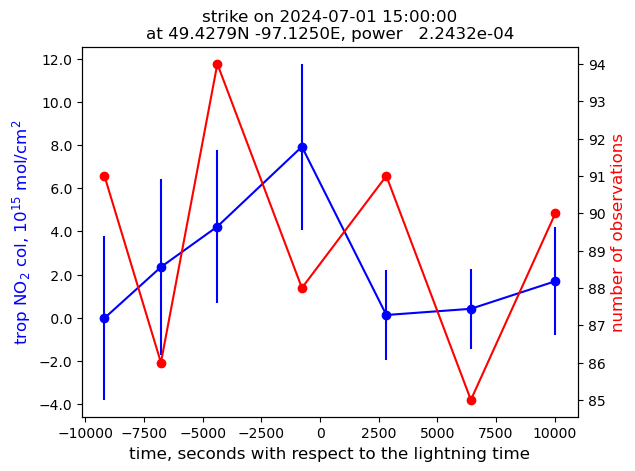

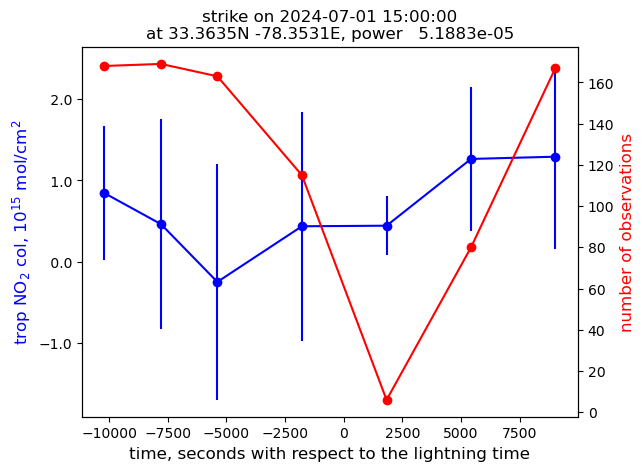

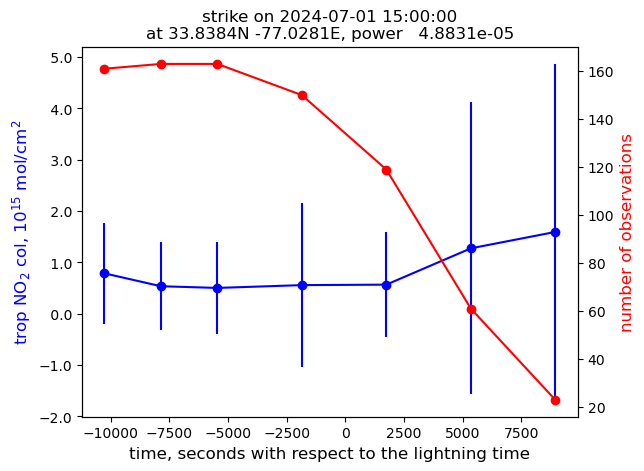

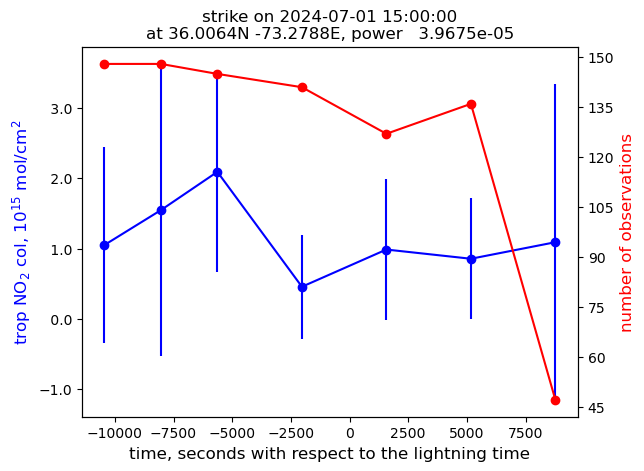

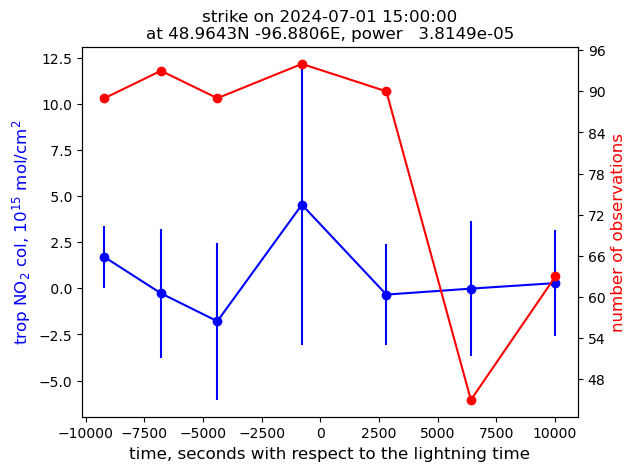

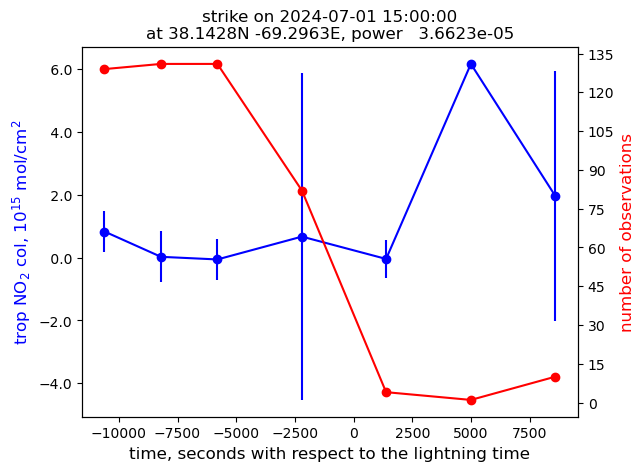

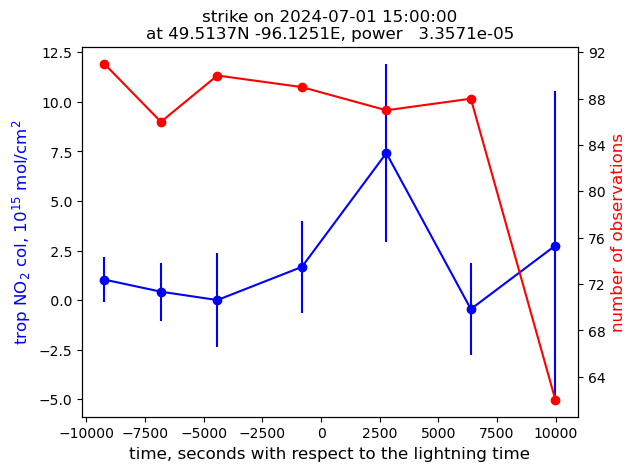

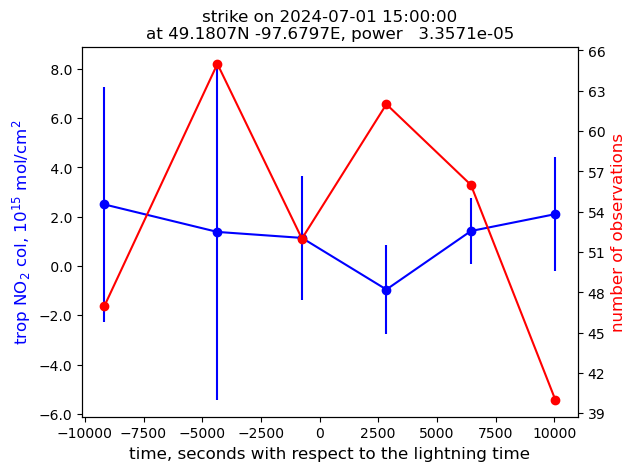

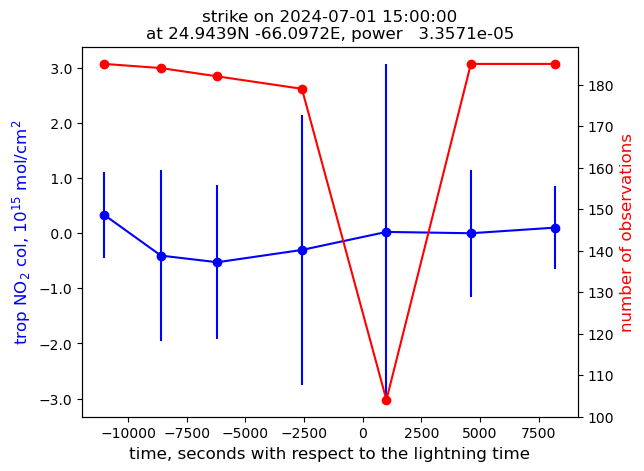

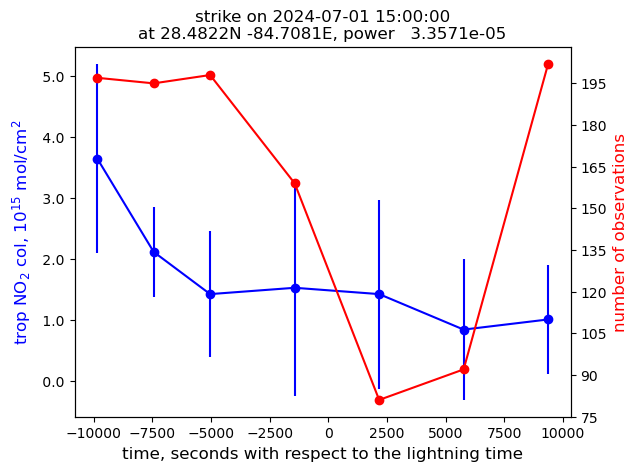

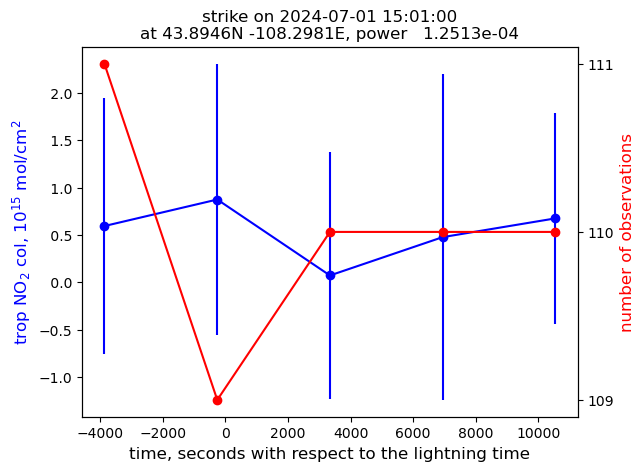

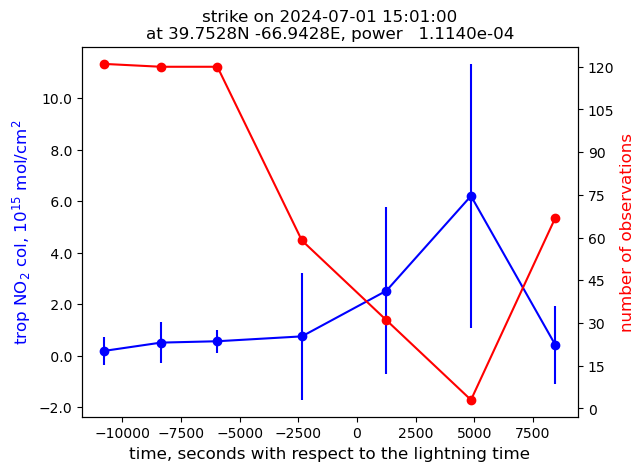

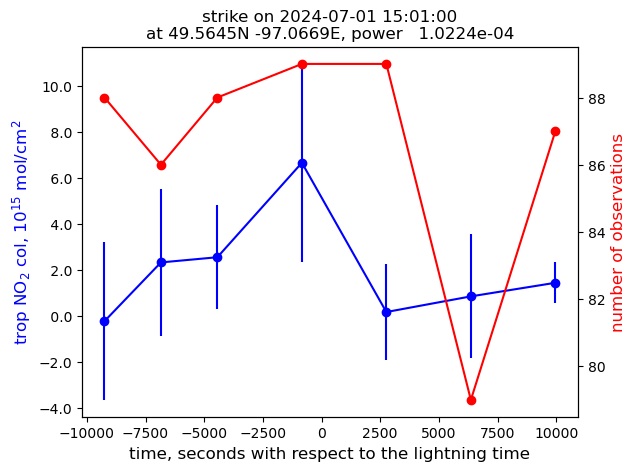

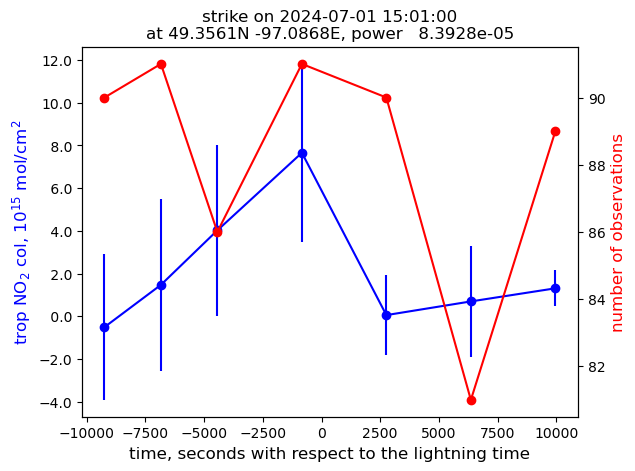

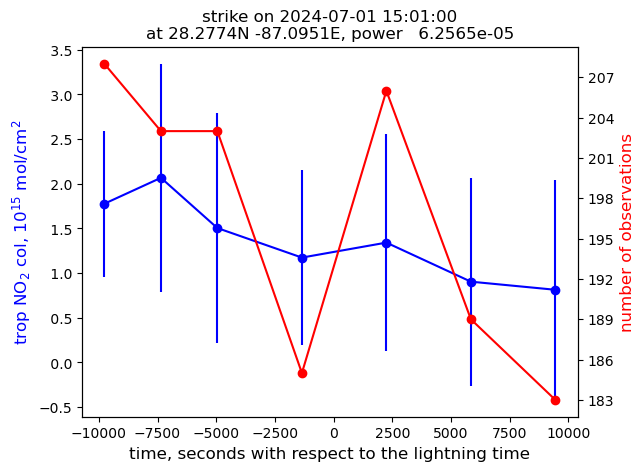

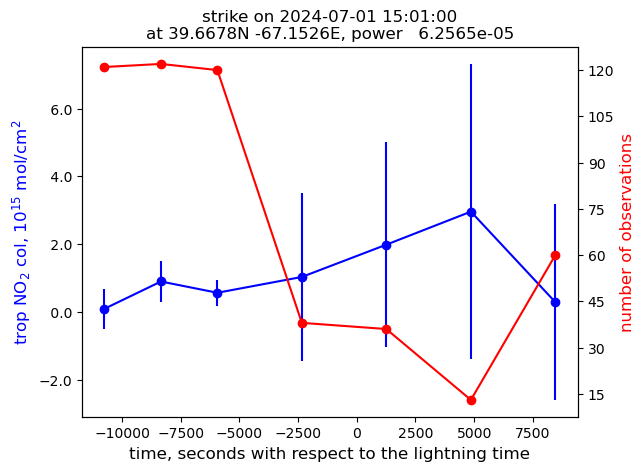

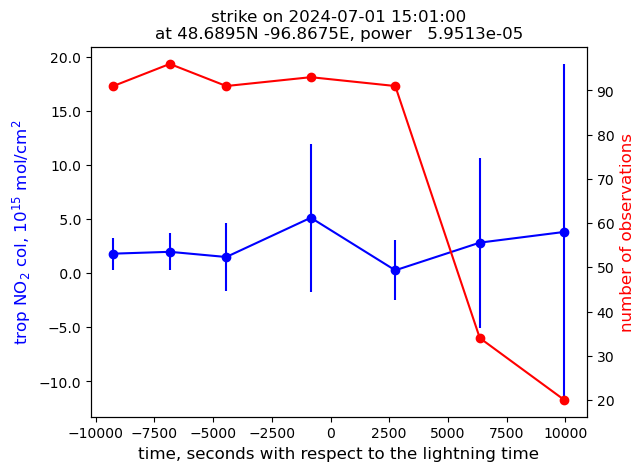

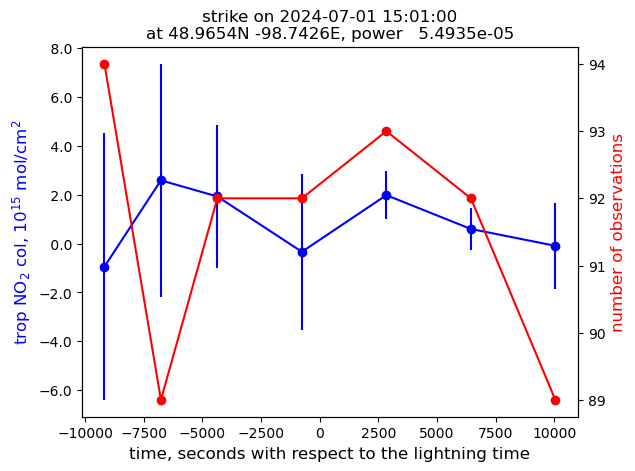

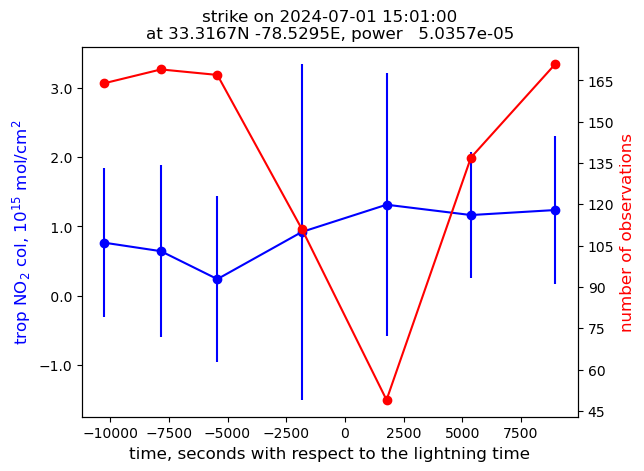

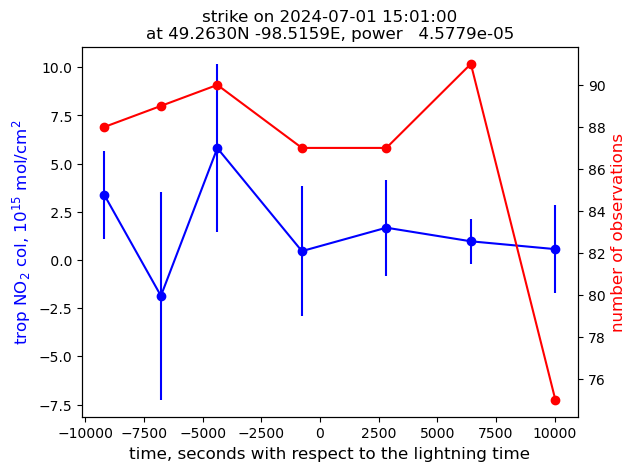

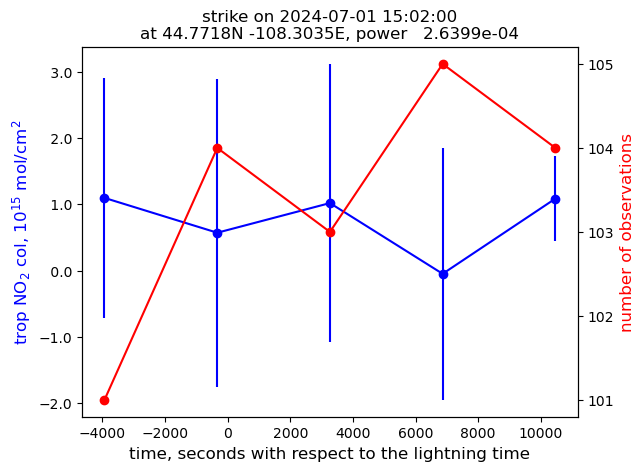

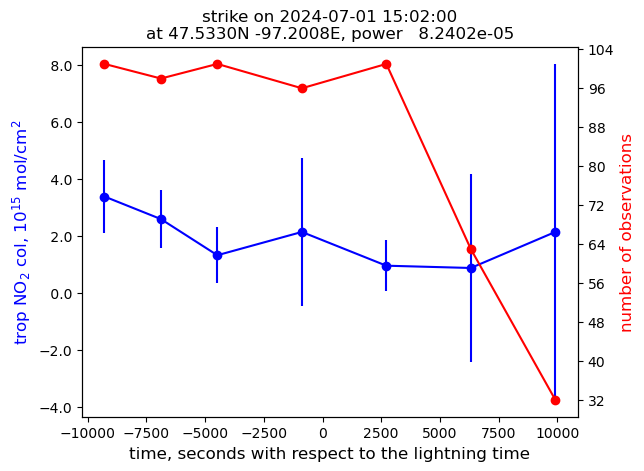

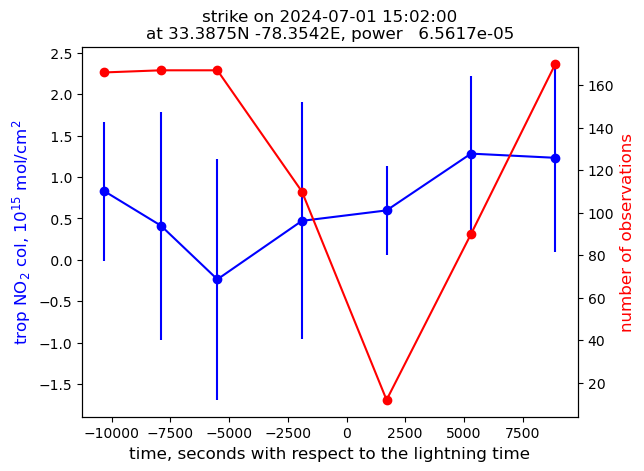

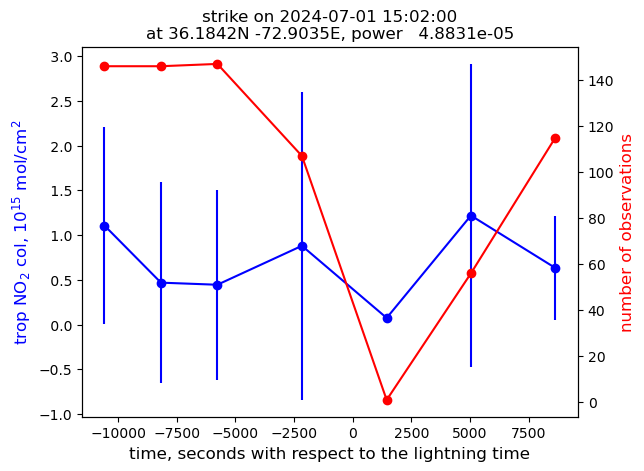

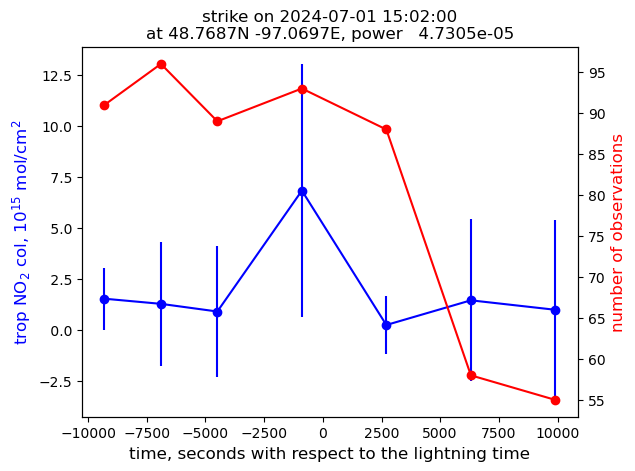

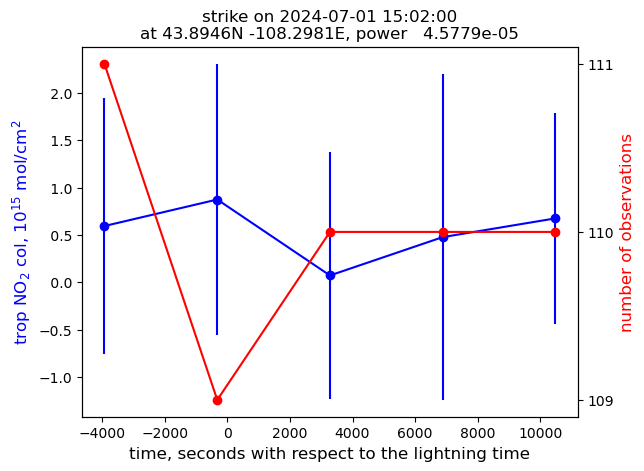

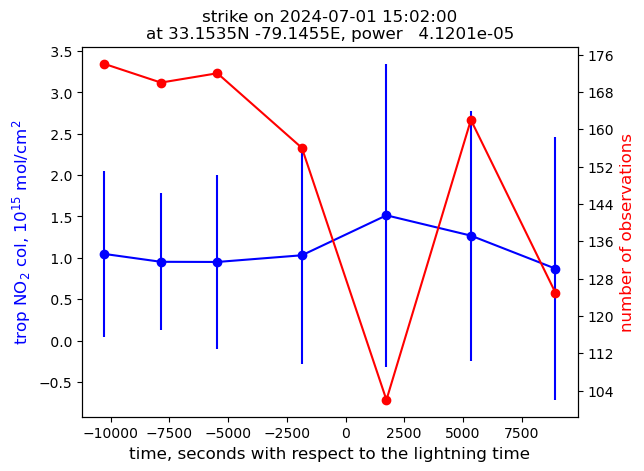

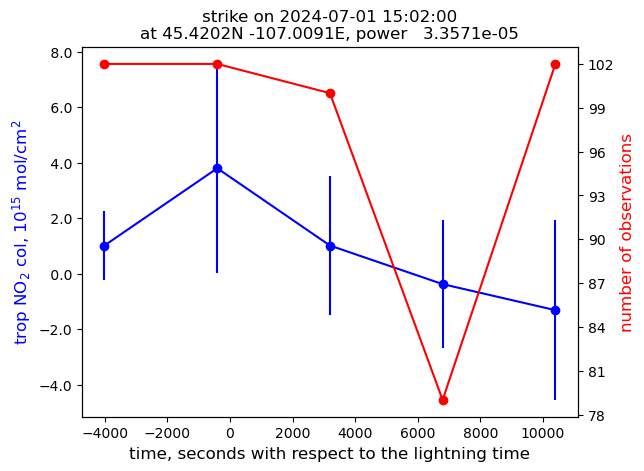

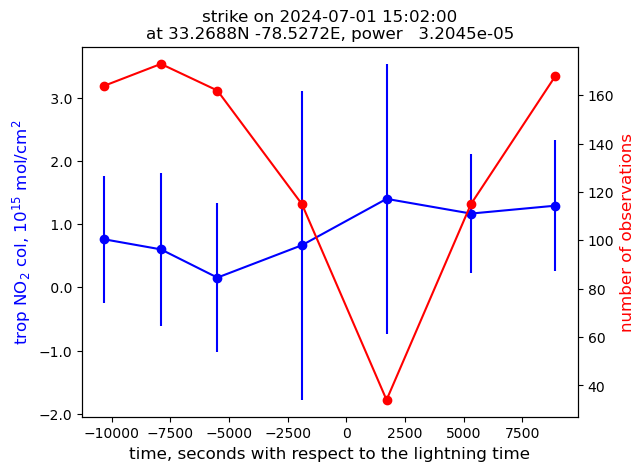

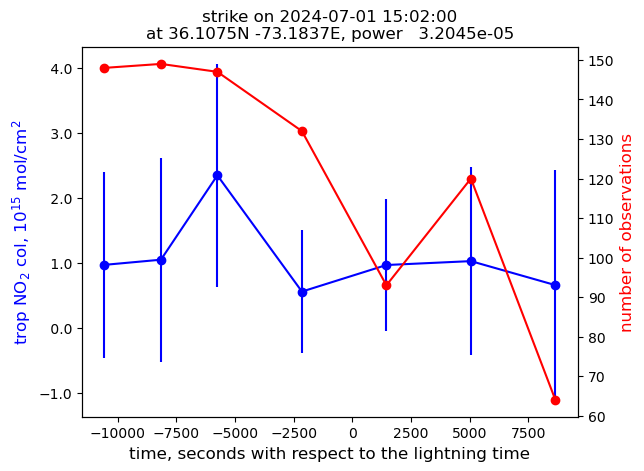

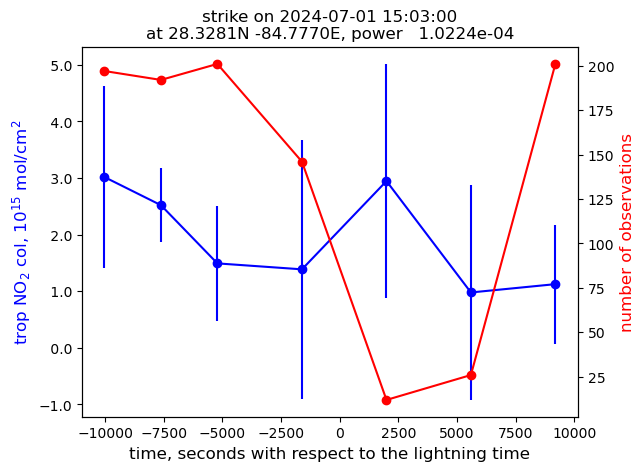

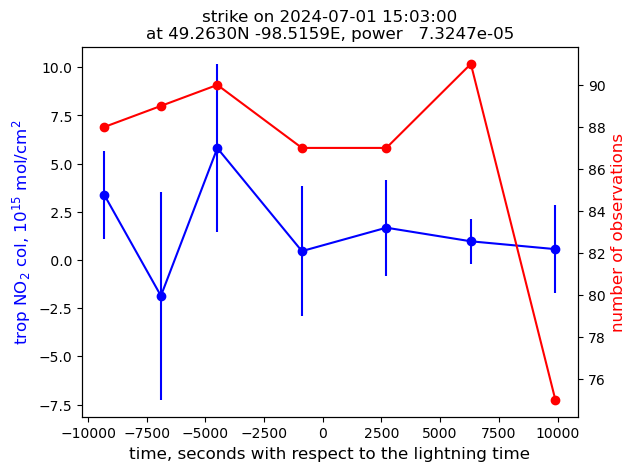

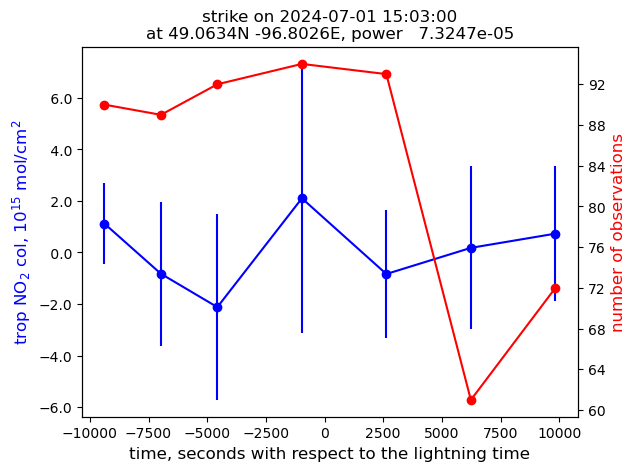

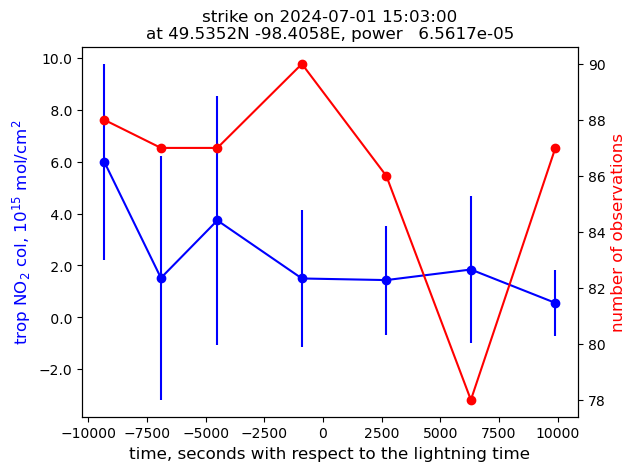

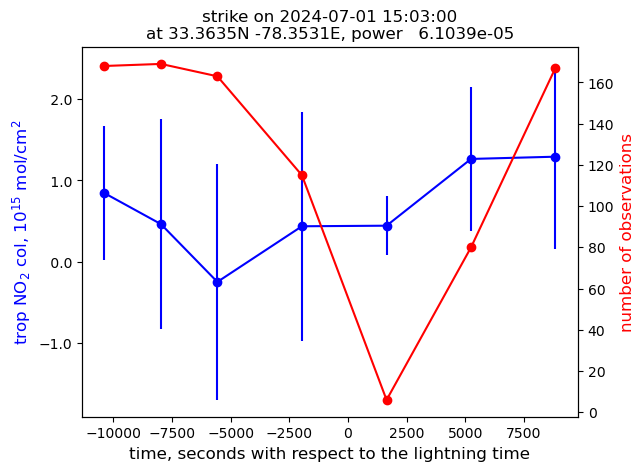

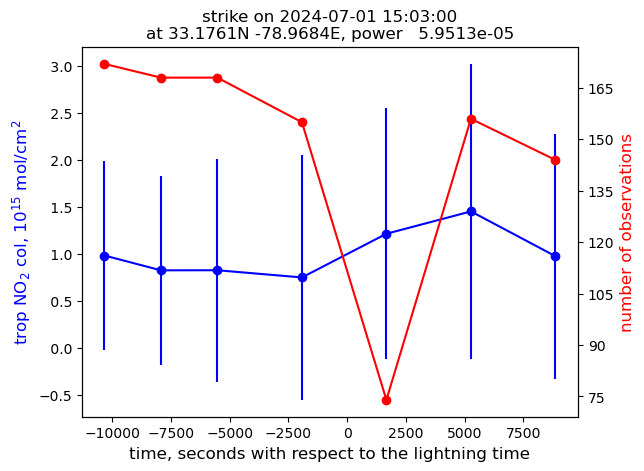

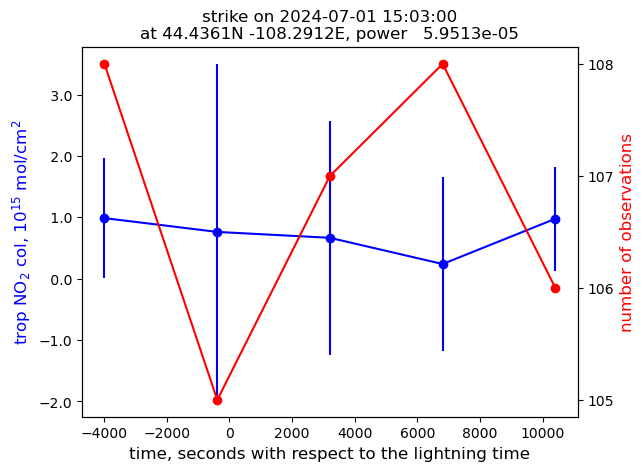

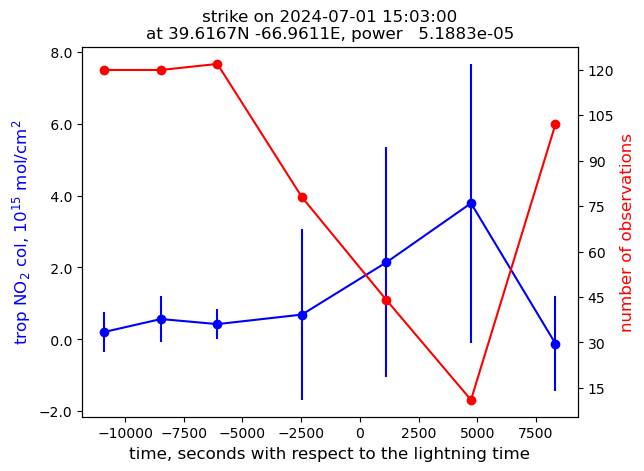

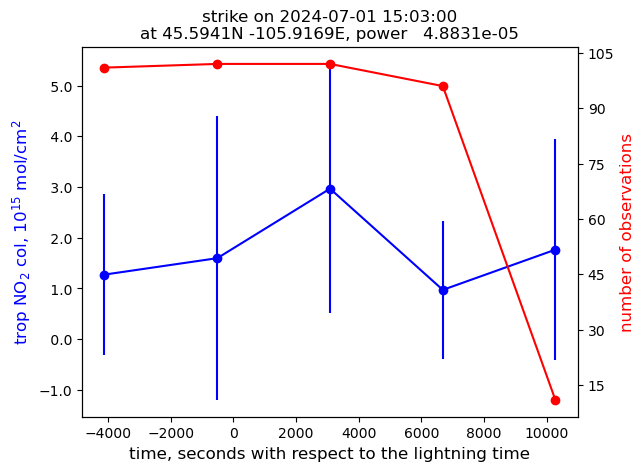

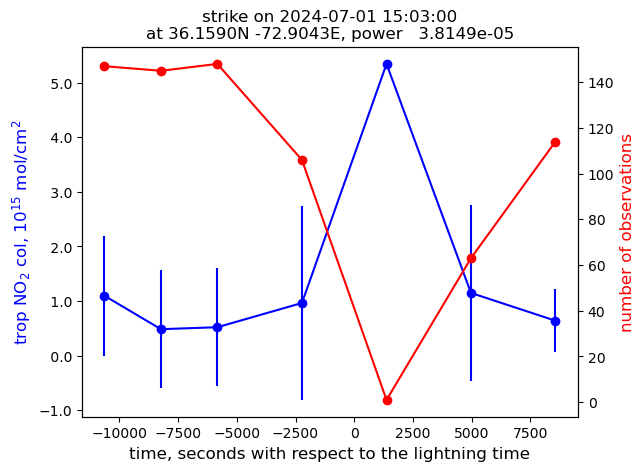

In [40]:
for local_timeseries, local_header, local_time in zip (all_strikes_timeseries, all_headers, all_times):
    plot_NO2_lightning(local_time, local_header[0:2], local_header[2], local_timeseries)

In [3]:
fin = open('NO2_lightning_timeseries_positive', 'r')
lines = fin.readlines()
fin.close()

all_strikes_timeseries = np.empty(0, dtype = object)
all_headers = np.empty([0, 3])
all_times = np.empty(0)
count = -1

for line in lines:
    if len(line) == 1:
        count = count + 1
        all_strikes_timeseries = np.append(all_strikes_timeseries, [None], axis = 0)
        all_strikes_timeseries[count] = local_timeseries
        all_headers = np.append(all_headers, [[lat, lon, power]], axis = 0)
        all_times = np.append(all_times, timestamp)
        continue

    if 'lightning time' in line:
        line_split = line.split()
        timestamp = line_split[2] + ' ' + line_split[3]
        [lat, lon] = [float(line_split[5][:-1]), float(line_split[6][:-1])]
        power = float(line_split[8])
        local_timeseries = np.empty([0, 6])
        continue

    if 'relative_TEMPO_time' in line: continue

#    print(line[:-1])
    line_split = line.split()
#    print(line_split)
    ts_line = np.empty(0)
    for s in line_split: ts_line = np.append(ts_line, float(s))
    local_timeseries = np.append(local_timeseries, [ts_line], axis = 0)

print(all_strikes_timeseries.shape, all_headers.shape, all_times.shape)

(40,) (40, 3) (40,)


In [35]:
def plot_pos_NO2_lightning(time, location, power, TEMPO_ts):
#    arguments:
#        time - time string from datetime;
#        location - numpy array of two element, latitude, longitude;
#        power - optical power of the strike from GLM product;
#        TEMPO_ts - numpy array containing timeseries of TEMPO NO2 tropospheric column, shape (number of measurements, 6)
#            columns:
#                TEMPO time relative to the time of lightning, seconds
#                NO2 tropospheric column averaged over all good measurements
#                NO2 tropospheric column standard deviation on all good measurements
#                minimum NO2 tropospheric column over all good measurements
#                maximum NO2 tropospheric column over all good measurements
#                number of good measurements of NO2 tropospheric column

    plot_title = 'strike on '+time+'\nat '+f'{location[0]:7.4f}N {location[1]:8.4f}E, power {power:12.4e}'
    if location[1] < 0: location_string = f'{location[0]:07.4f}N_{-location[1]:08.4f}W'
    else: location_string = f'{location[0]:07.4f}N_{location[1]:08.4f}E'
    ts = datetime.strptime(time, "%Y-%m-%d %H:%M:%S").strftime("%Y%m%dT%H%M%S")
    img_name = 'positive_tropNO2_timeseries_'+ts+'_'+location_string+'.jpg'

    fig, ax1 = plt.subplots()
    ax1.errorbar(TEMPO_ts[:, 0], TEMPO_ts[:, 1]*1.e-15, yerr=TEMPO_ts[:, 2]*1.e-15, fmt='-o', c = 'b')

    ax1.set_xlabel('time, seconds with respect to the lightning time', fontsize=12)
    ax1.set_ylabel('trop NO$_2$ col, 10$^{15}$ mol/cm$^2$', fontsize=12, color='blue')
    ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:4.1f}"))

    ax2 = ax1.twinx()
    ax2.plot(TEMPO_ts[:, 0], TEMPO_ts[:, 5], '-o', c='r')
    ax2.set_ylabel('number of positive observations', fontsize=12, color='red')
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    plt.title(plot_title)
    plt.savefig(img_name, format='jpg', dpi=300)
    plt.show()
    plt.close()

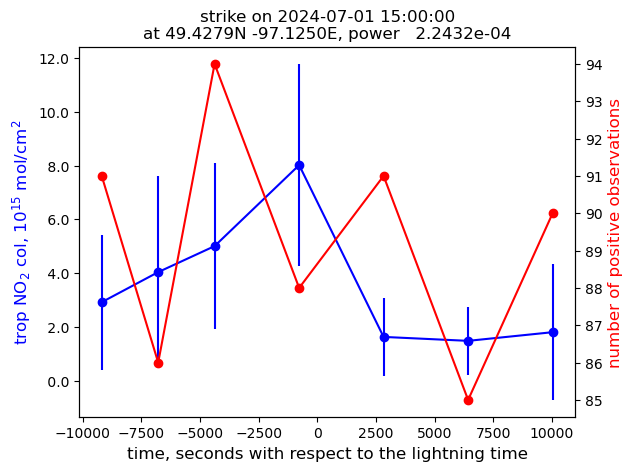

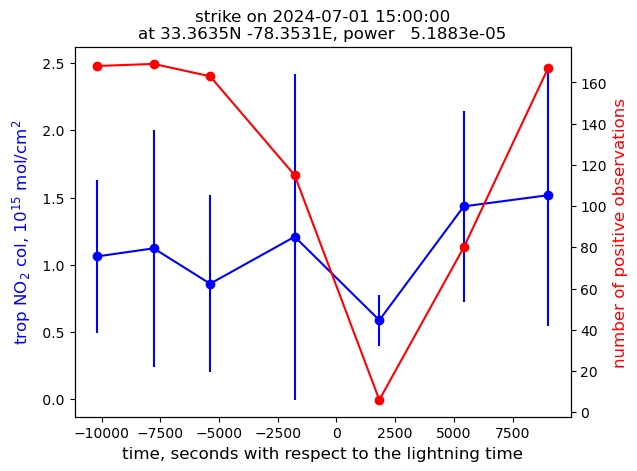

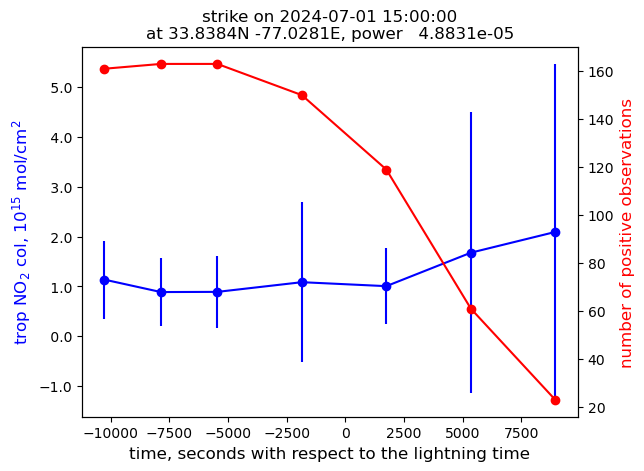

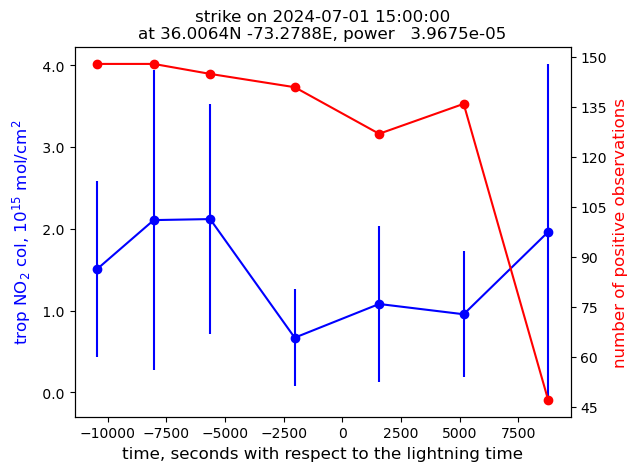

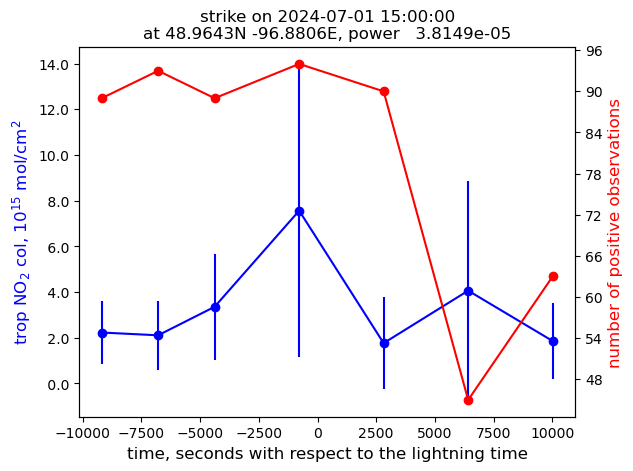

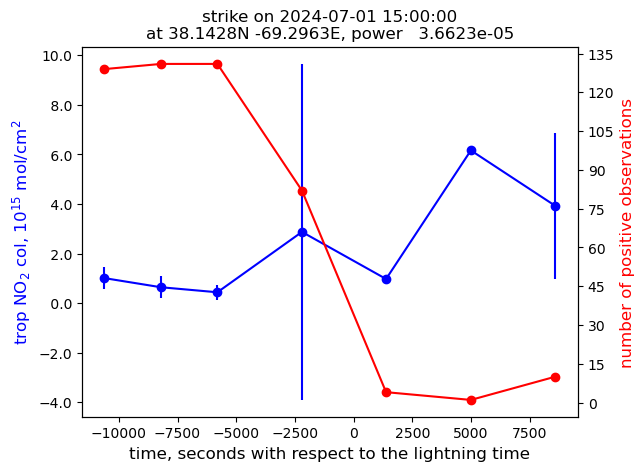

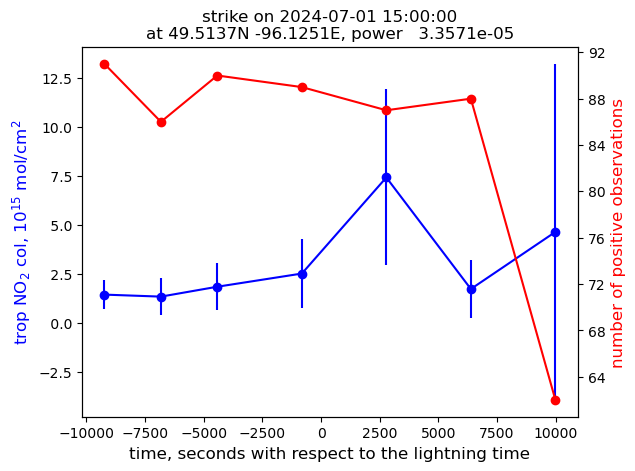

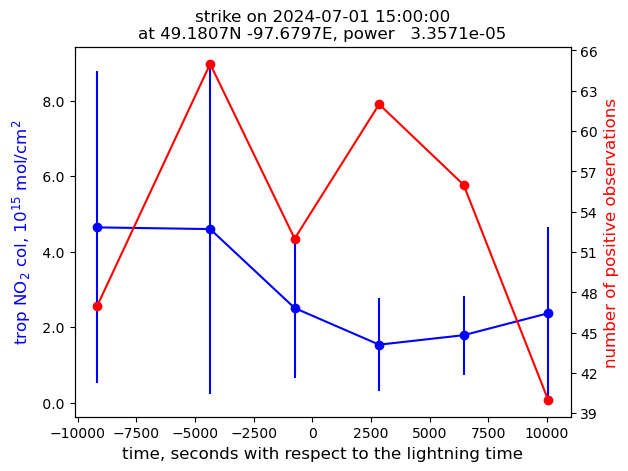

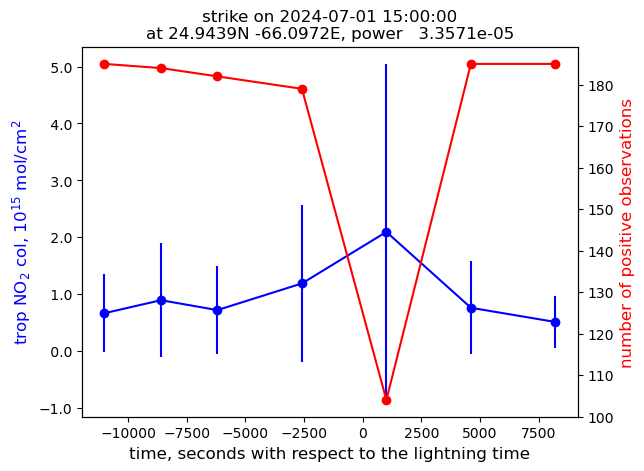

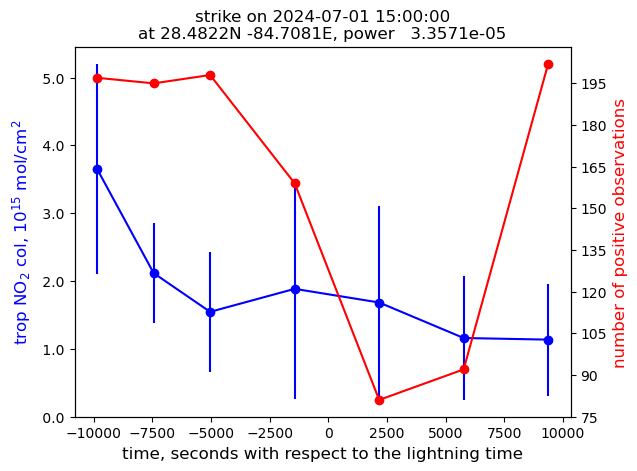

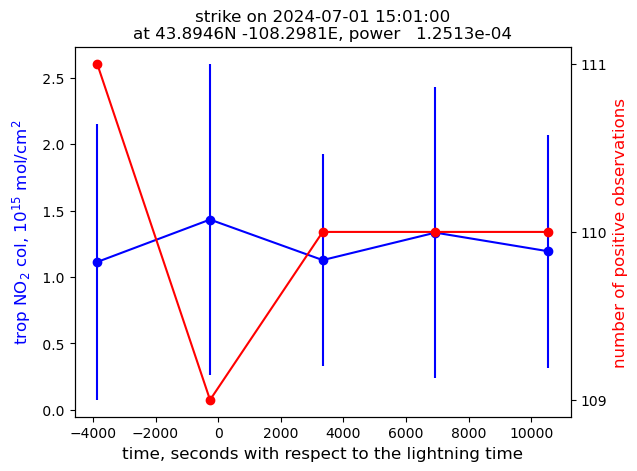

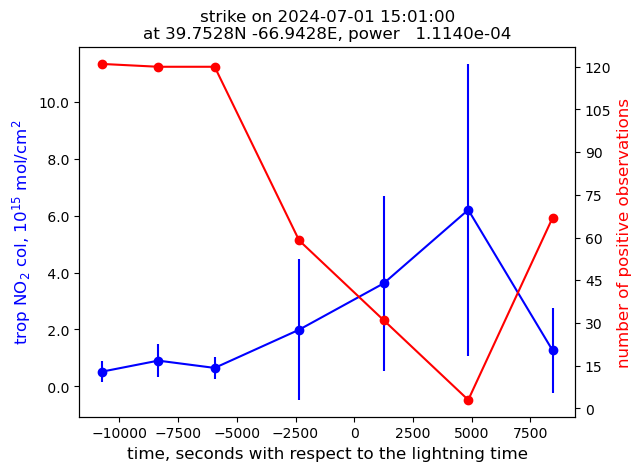

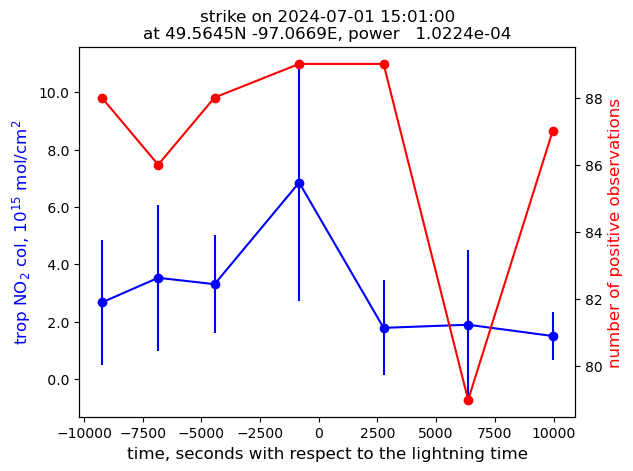

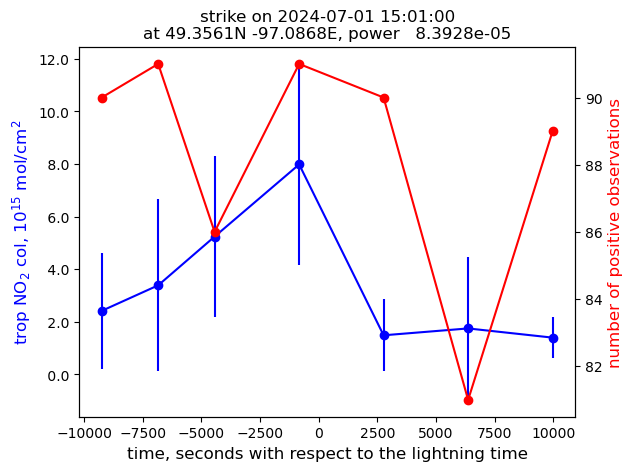

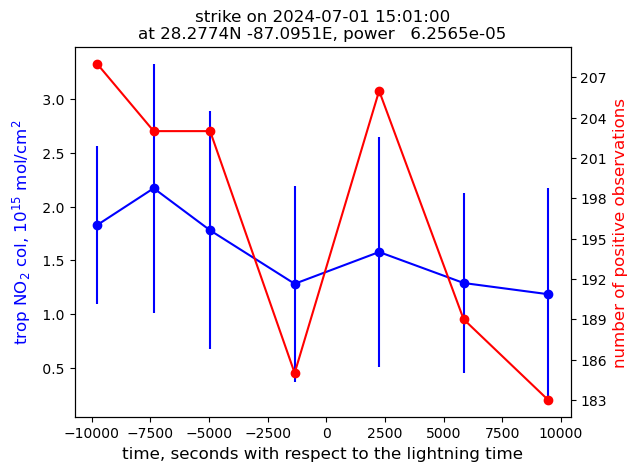

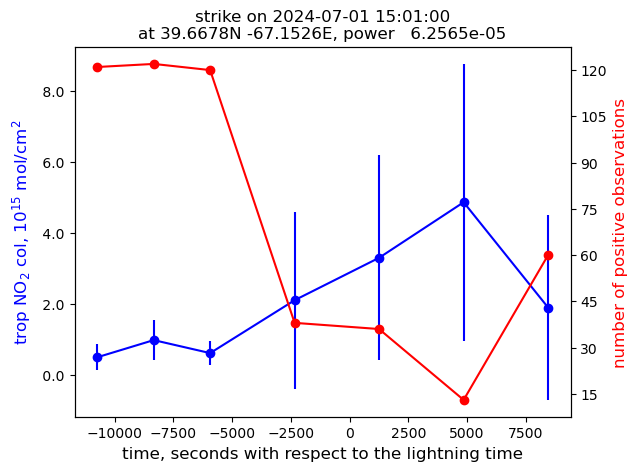

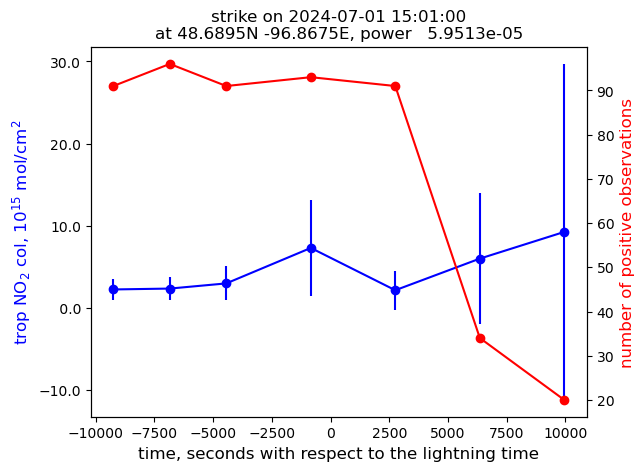

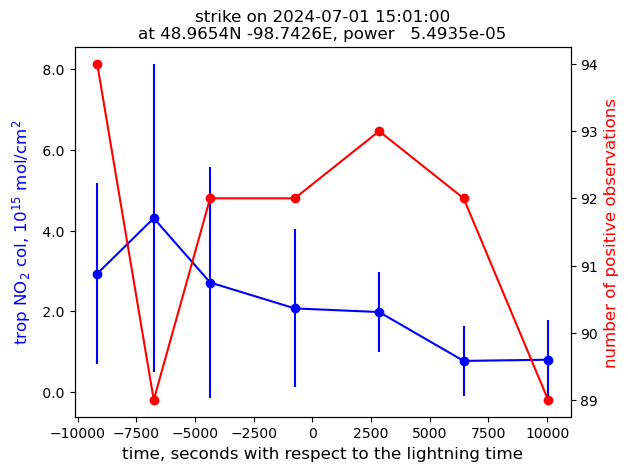

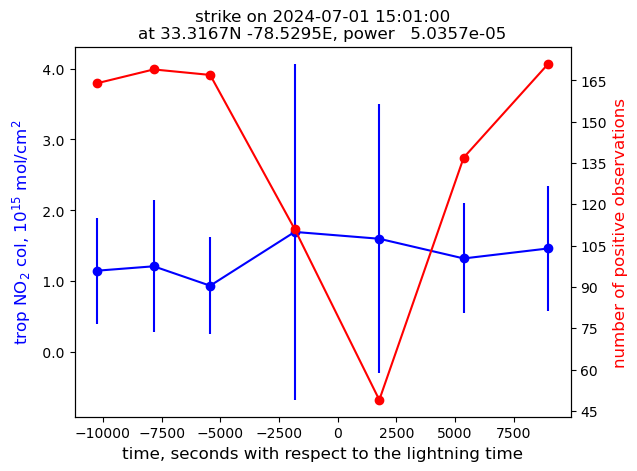

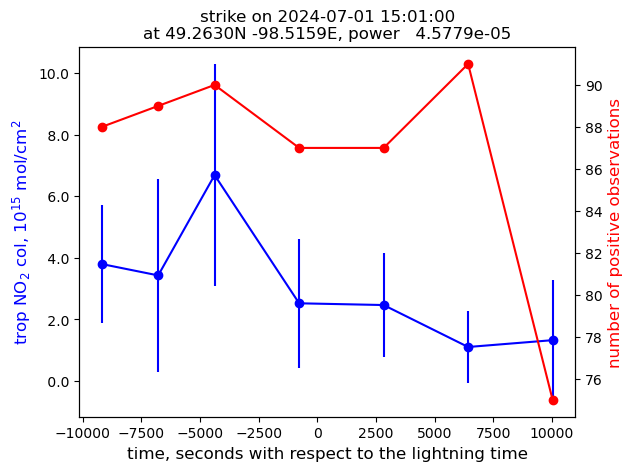

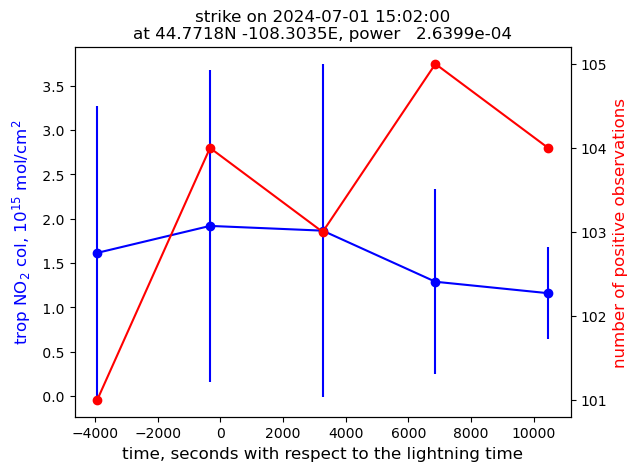

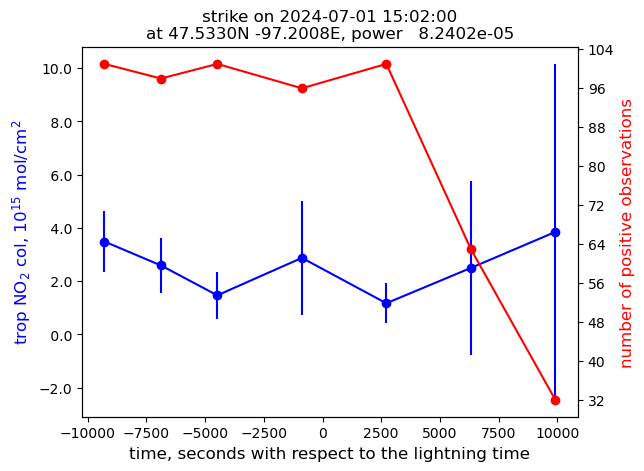

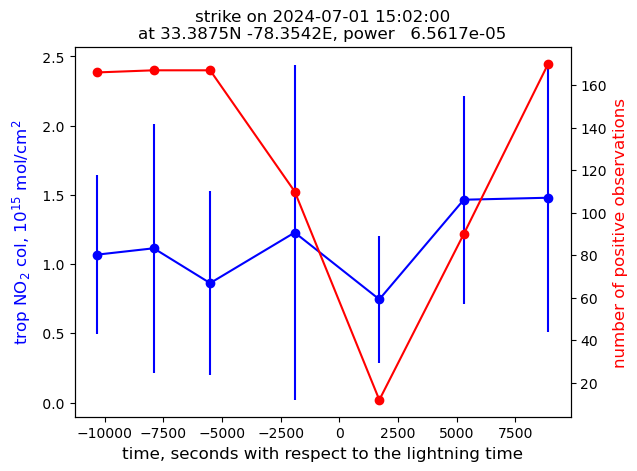

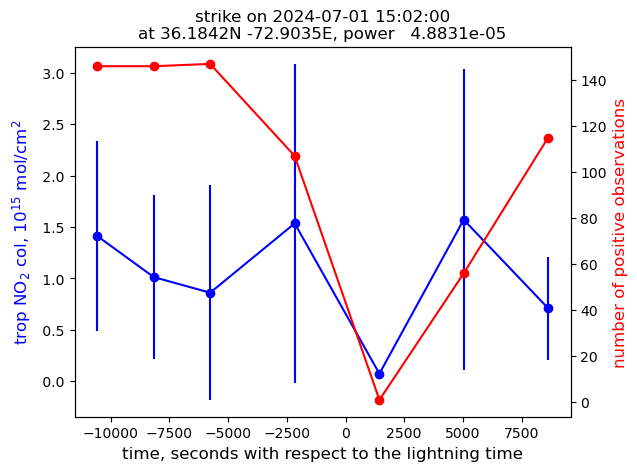

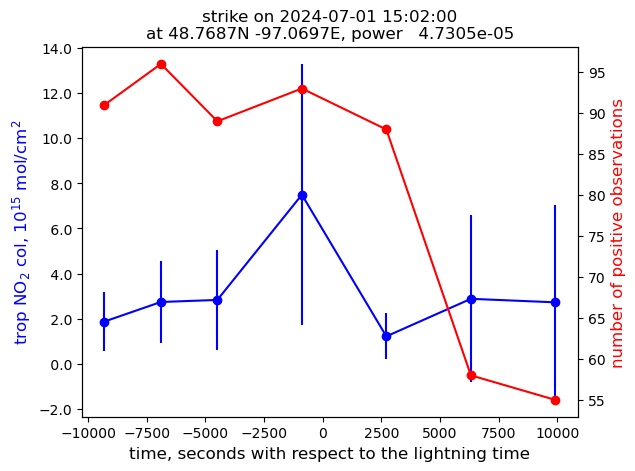

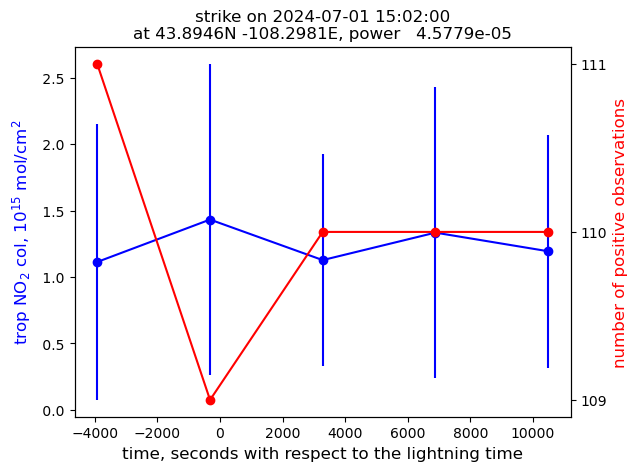

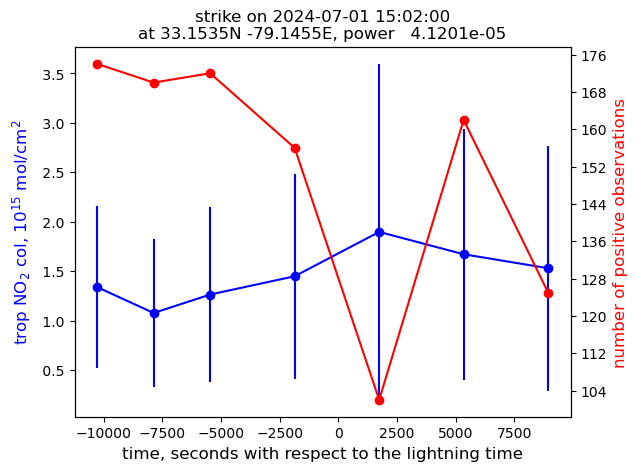

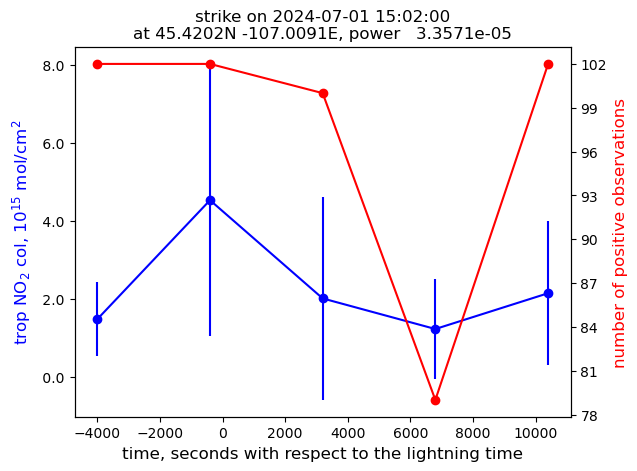

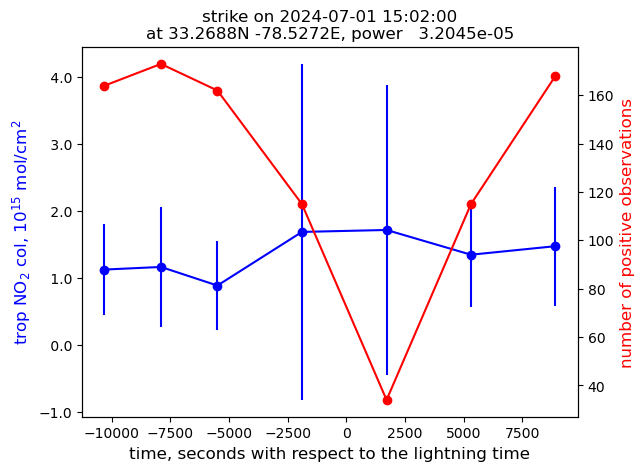

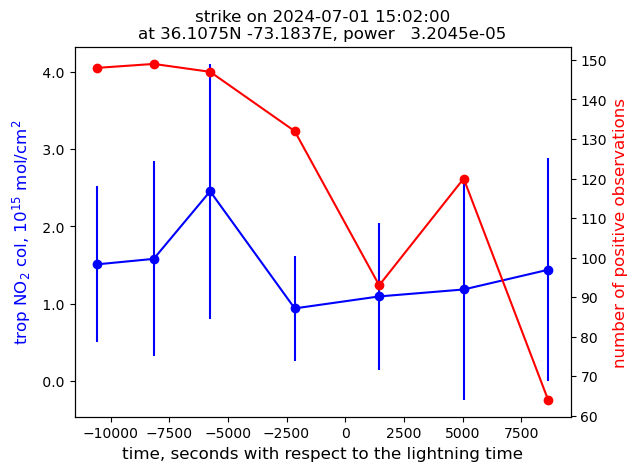

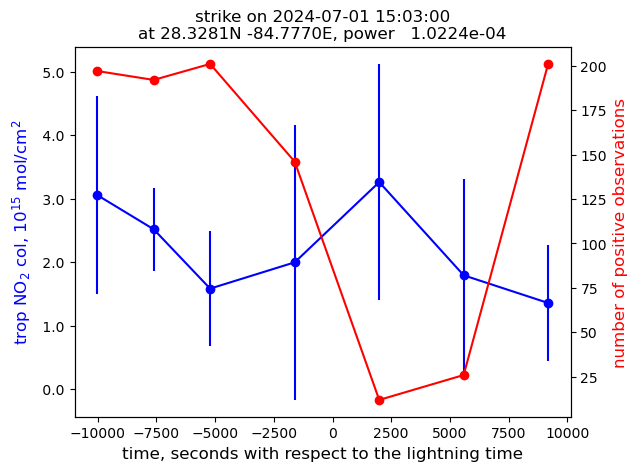

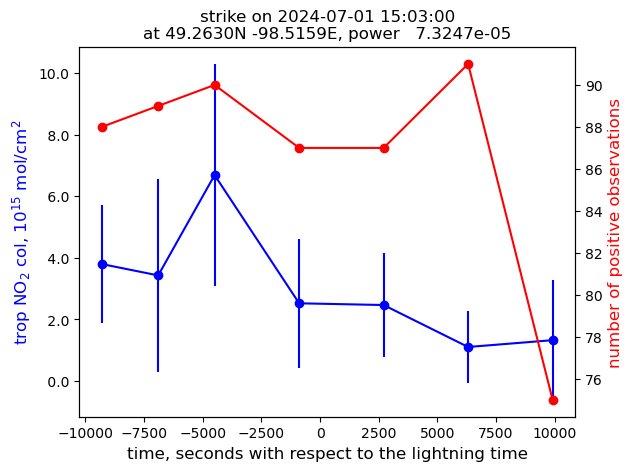

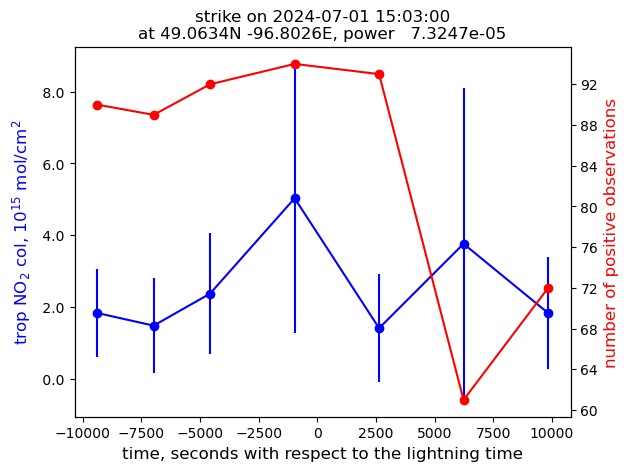

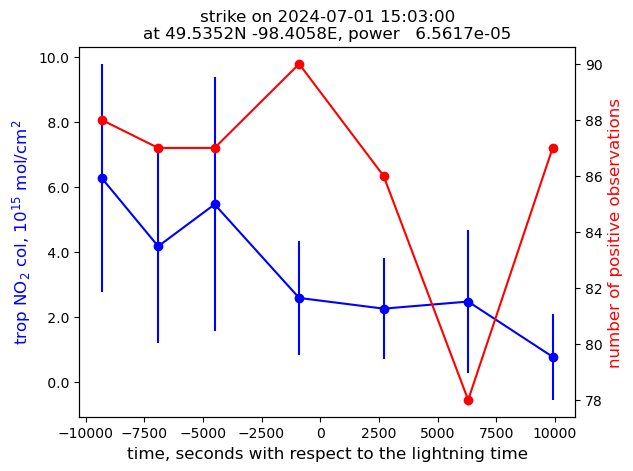

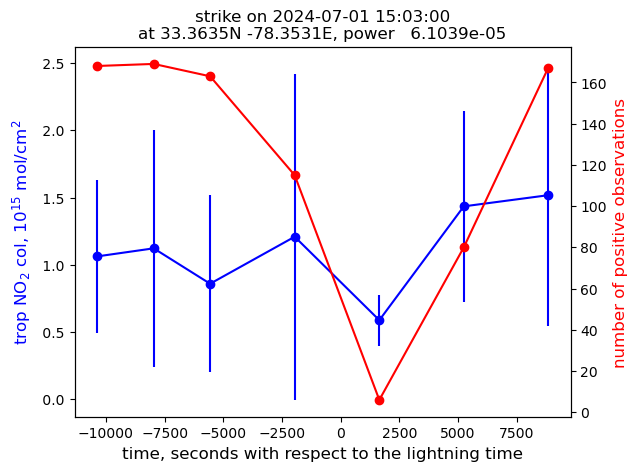

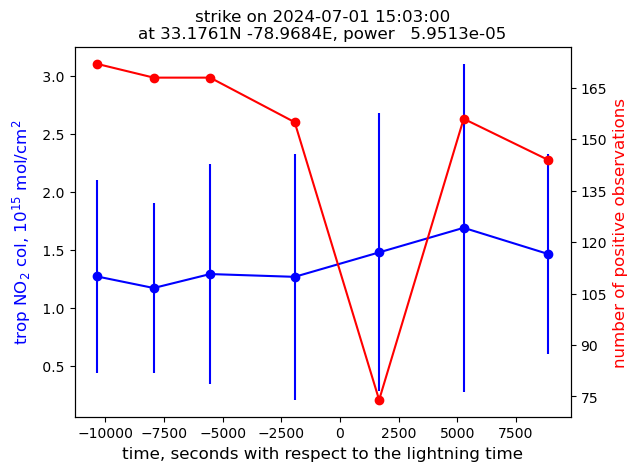

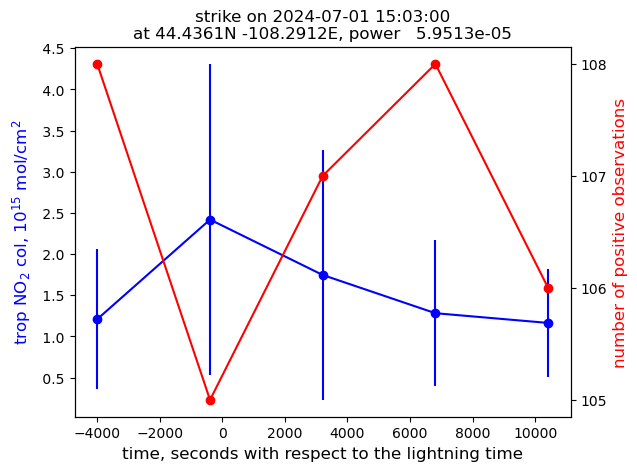

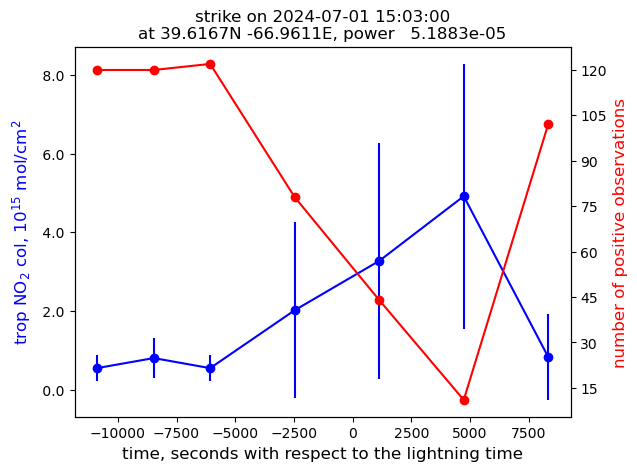

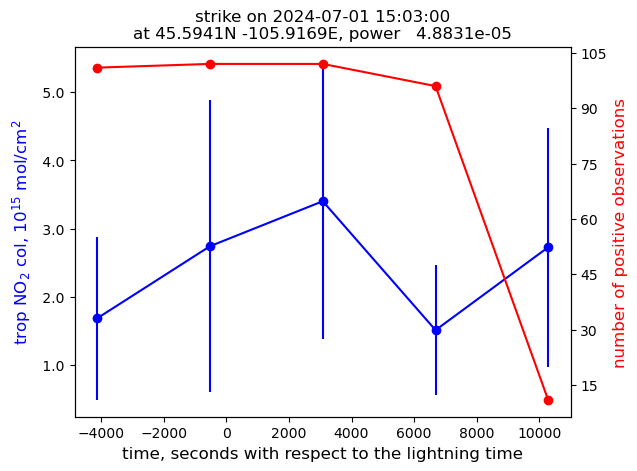

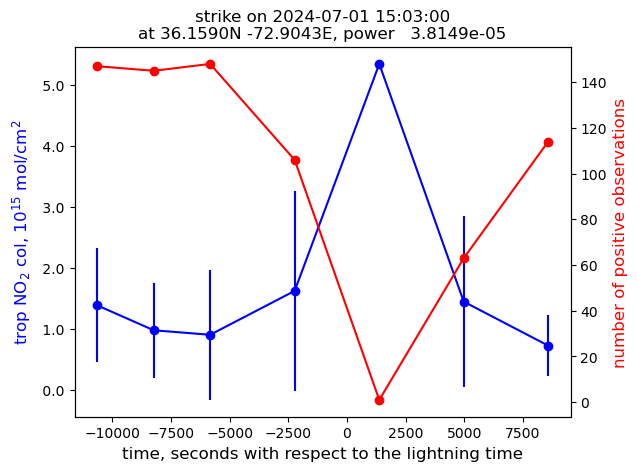

In [36]:
for local_timeseries, local_header, local_time in zip (all_strikes_timeseries, all_headers, all_times):
    plot_pos_NO2_lightning(local_time, local_header[0:2], local_header[2], local_timeseries)

# Archive output images

In [44]:
import zipfile
import glob

img_list = glob.glob('*.jpg')

with zipfile.ZipFile("img.zip", mode="w") as archive:
    for img in img_list: archive.write(img)